# Notebook 4: Spatial Statistics with `squidpy`

**Instructor:** Anthony Christidis 
**Time:** 45 minutes

---

Welcome to our deep dive into spatial statistics! In the previous notebook, we processed our high-resolution **Xenium data** and identified cell clusters. Now, we will use `squidpy` to ask advanced biological questions about the spatial organization of those cells and genes.

**Goals:**
1.  Identify spatially organized genes using **Moran's I**.
2.  Analyze cell community structures using **neighborhood enrichment**.
3.  Quantify how often different cell types appear near each other using **co-occurrence** analysis.

### Setup and Data Loading

We will start by loading the **fully processed and clustered Xenium `AnnData` object** that we saved at the end of the previous notebook. This allows us to jump straight into the spatial analysis.

In [1]:
%load_ext jupyter_black

import anndata as ad
import squidpy as sq
import scanpy as sc

import warnings
warnings.filterwarnings("ignore")

# Load the processed AnnData object
adata_xenium = ad.read_h5ad("../data/processed/adata_xenium_processed.h5ad")
print("Processed Xenium data loaded.")

C:\Users\anthony\miniconda3\envs\spatial-workshop\Lib\site-packages\dask\dataframe\__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
C:\Users\anthony\miniconda3\envs\spatial-workshop\Lib\site-packages\xarray_schema\__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution
C:\Users\anthony\miniconda3\envs\spatial-workshop\Lib\site-packages\anndata\__init__.py:44: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  return module_get_attr_

Processed Xenium data loaded.


In [2]:
adata_xenium

AnnData object with n_obs × n_vars = 74052 × 377
    obs: 'cell_id', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'region', 'z_level', 'nucleus_count', 'cell_labels', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_in_top_50_genes', 'n_counts', 'clusters'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters', 'clusters_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'spatialdata_attrs', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

### Building the Spatial Graph

All of `squidpy`'s tools rely on a **spatial neighborhood graph**. This graph connects cells that are physically close to each other in the tissue. We build it once from the cell coordinates, and then we can use it for many different analyses.

Note: The coordinates were not saved in the `.h5ad` file, so we need to re-extract them from the original `SpatialData` object.

In [4]:
import spatialdata as sd

# Load the original sdata object just to get the coordinates
sdata_xenium = sd.read_zarr("../data/xenium_lung_cancer_subset.zarr")

# Use .loc to safely get the coordinates for our processed cells
adata_xenium.obsm['spatial'] = sdata_xenium.shapes['cell_circles'].loc[adata_xenium.obs_names].centroid.apply(lambda p: [p.x, p.y]).to_numpy()

# Now, build the graph
sq.gr.spatial_neighbors(adata_xenium, coord_type="generic", delaunay=True)

KeyError: "None of [Index(['2', '5', '6', '8', '9', '10', '12', '16', '24', '30',\n       ...\n       '161914', '161915', '161935', '161940', '161985', '162067', '162072',\n       '162075', '162195', '162203'],\n      dtype='object', length=74052)] are in the [index]"

Let's visualize the clusters we found in the previous notebook to confirm everything is correct.

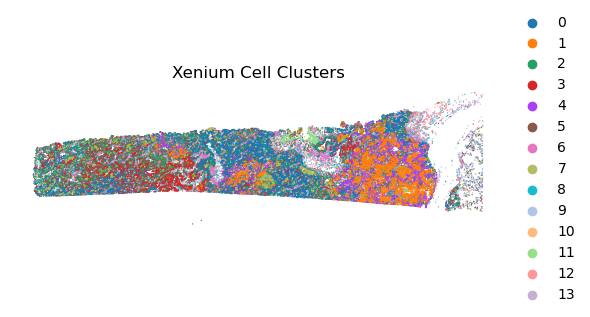

In [5]:
sc.pl.spatial(adata_xenium, color="clusters", spot_size=30, frameon=False, title="Xenium Cell Clusters")

### Analysis 1: Spatially Variable Genes (Moran's I)

**Biological Question:** Which genes' expression levels are not random, but are clustered in specific tissue regions? This helps identify genes that define anatomical structures.

In [6]:
# Calculate Moran's I using the graph we just built
# We'll test only the highly variable genes we found earlier for speed.
sq.gr.spatial_autocorr(adata_xenium, mode="moran", genes=adata_xenium.var.highly_variable, n_perms=100, n_jobs=4)

# Show the top results, sorted by the 'I' score
adata_xenium.uns["moranI"].sort_values(by="I", ascending=False).head()

KeyError: "Spatial connectivity key `spatial_connectivities` not found in `adata.obsp`. Please run `squidpy.gr.spatial_neighbors(..., key_added='spatial')` first."

Now we can visualize the expression of the top-scoring gene using `scanpy`'s robust spatial plotting function.

In [ ]:
top_gene = adata_xenium.uns["moranI"].sort_values(by="I", ascending=False).index[0]
sc.pl.spatial(adata_xenium, color=top_gene, spot_size=30, frameon=False, title=f"{top_gene} Expression")

### Analysis 2: Neighborhood Enrichment

Now let's analyze the organization of our cell clusters.

**Biological Question:** Which cell types (Leiden clusters) are found together more or less often than expected by chance? This helps us find potential cell-cell communication hubs or excluded cell populations.

In [ ]:
sq.gr.nhood_enrichment(adata_xenium, cluster_key="clusters")

We visualize this as a heatmap. Bright yellow indicates that two clusters are often neighbors (co-enriched), while dark purple indicates they tend to avoid each other (depleted).

In [ ]:
sq.pl.nhood_enrichment(adata_xenium, cluster_key="clusters", method="ward", cmap="viridis")

This plot gives us powerful, quantifiable insights into the tissue's "social network." For example, we might discover a strong interaction between immune cells and tumor cells based on a high enrichment score.

### Workshop Conclusion
Congratulations! You have now completed a full spatial analysis workflow, from QC and clustering to advanced spatial statistics. You are now equipped with the core `scverse` tools to begin exploring your own spatial datasets.